In [1]:
import copy
import os
import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from torch import nn
from sklearn.metrics import accuracy_score

In [2]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [3]:
from cassava.utils import *
from cassava.transforms import get_train_transforms, get_test_transforms

In [4]:
from pl_bolts.models.self_supervised import MocoV2

In [5]:
from pytorch_lightning import Trainer
from argparse import Namespace

In [6]:
from cassava.models.model import LeafDoctorModel

# Prepare data

In [7]:
train_images_torch = context.catalog.load('train_images_torch')

2020-12-13 14:53:02,028 - kedro.io.data_catalog - INFO - Loading data from `train_images_torch` (ImageFolderDataSet)...


In [8]:
train_labels = context.catalog.load('train_labels')

2020-12-13 14:53:02,061 - kedro.io.data_catalog - INFO - Loading data from `train_labels` (CSVDataSet)...


In [9]:
parameters = context.catalog.load('parameters')

2020-12-13 14:53:02,096 - kedro.io.data_catalog - INFO - Loading data from `parameters` (MemoryDataSet)...


In [10]:
parameters

{'seed': 42,
 'cv_splits': 3,
 'cv_models_dir': 'data/06_models/cv_folds',
 'validation_size': 0.15,
 'data_loader_workers': 4,
 'classifier': {'gpus': -1,
  'batch_size': 10,
  'max_epochs': 100,
  'max_steps': 0,
  'auto_lr_find': 0,
  'lr': 0.001,
  'weight_decay': 0.0001,
  'early_stop_patience': 4,
  'reduce_lr_on_pleteau_patience': 2,
  'save_top_k_checkpoints': 1,
  'checkpoints_dir': 'data/06_models/classifier/checkpoints'},
 'byol': {'gpus': -1,
  'batch_size': 10,
  'max_epochs': 100,
  'max_steps': 0,
  'auto_lr_find': 0,
  'lr': 0.01,
  'step_lr': 3,
  'step_lr_gamma': 0.5,
  'weight_decay': 0.0001,
  'limit_val_batches': 1,
  'accumulate_grad_batches': 4,
  'early_stop_patience': 6}}

In [11]:
res = context.pipelines['train'].nodes[0].run({'train_labels': train_labels, 'parameters': parameters})
train_indices = np.array(res['train_indices'])
val_indices = np.array(res['val_indices'])

2020-12-13 14:53:02,109 - kedro.pipeline.node - INFO - Running node: split: split_data([parameters,train_labels]) -> [train_indices,val_indices]


In [12]:
train_indices.shape, val_indices.shape

((18187,), (3210,))

In [13]:
unnorm = Unnormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [14]:
raw_transforms = A.Compose([
        ToTensorV2(),
])

def get_train_transforms():
    return A.Compose([
        #A.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=5, val_shift_limit=5, p=1),
        A.ToFloat(max_value=1.0),
        A.RandomResizedCrop(256, 256, scale=(0.3, 0.9)),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])


def get_test_transforms():
    return A.Compose([
        A.ToFloat(max_value=1.0),
        A.CenterCrop(400, 400),
        A.Resize(256, 256),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])

In [15]:
train_transform, val_transform = get_train_transforms(), get_test_transforms()

train_dataset = DatasetFromSubset(torch.utils.data.Subset(train_images_torch, indices=train_indices),
                                      transform=train_transform)

val_dataset = DatasetFromSubset(torch.utils.data.Subset(train_images_torch, indices=val_indices),
                                transform=val_transform)

train_data_loader = torch.utils.data.DataLoader(train_dataset,
                                                batch_size=parameters['classifier']['batch_size'],
                                                num_workers=parameters['data_loader_workers'],
                                                shuffle=True)

val_data_loader = torch.utils.data.DataLoader(val_dataset, num_workers=parameters['data_loader_workers'], batch_size=parameters['classifier']['batch_size'])

In [16]:
raw_dataset = DatasetFromSubset(torch.utils.data.Subset(train_images_torch, indices=list(range(len(train_images_torch)))), transform=raw_transforms)
augmented_dataset = DatasetFromSubset(torch.utils.data.Subset(train_images_torch, indices=list(range(len(train_images_torch)))), transform=get_train_transforms())
test_aug_dataset = DatasetFromSubset(torch.utils.data.Subset(train_images_torch, indices=list(range(len(train_images_torch)))), transform=get_test_transforms())

3


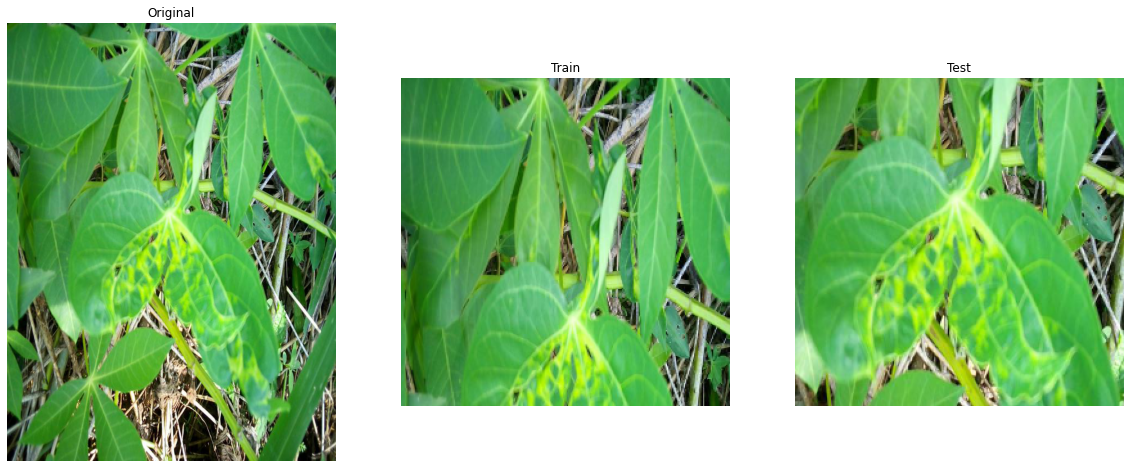

In [17]:
idx = np.random.choice(range(len(train_images_torch)))
raw_image, label = raw_dataset[idx]
aug_image, _ = augmented_dataset[idx]
test_aug_image, _ = test_aug_dataset[idx]

print(label)
plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plot_image(raw_image/255)
plt.title('Original')
plt.subplot(1, 3, 2)
plot_image(unnorm(aug_image))
plt.title('Train')
plt.subplot(1, 3, 3)
plot_image(unnorm(test_aug_image))
plt.title('Test')
plt.show()

In [18]:
raw_image.shape, aug_image.shape, test_aug_image.shape

(torch.Size([3, 600, 800]),
 torch.Size([3, 256, 256]),
 torch.Size([3, 256, 256]))

# Define model

In [19]:
from cassava.models.byol import *

In [20]:
#parameters['auto_lr_find'] = True
# parameters['lr'] = 0.1
hparams_classifier = Namespace(**parameters['classifier'])
hparams_byol = Namespace(**parameters['byol'])

In [21]:
model = LeafDoctorModel(hparams_classifier)

In [22]:
byol = BYOL(model.trunk, image_size=(256, 256), hparams=hparams_byol)

## Check BYOL augmentations

In [23]:
from kornia import augmentation as aug
from kornia import filters
from kornia.geometry import transform as tf
import torch
from torch import nn, Tensor

In [24]:
def byol_aug(image_size = (224, 224)):
    return nn.Sequential(
        tf.Resize(size=image_size),
        RandomApply(aug.ColorJitter(0.1, 0.1, 0.1, 0.1), p=0.8),
        aug.RandomHorizontalFlip(),
        RandomApply(filters.GaussianBlur2d((3, 3), (1.0, 1.0)), p=0.1),
        aug.RandomResizedCrop(size=image_size, scale=(0.3, 0.7)),
        aug.Normalize(
            mean=torch.tensor([0.485, 0.456, 0.406]),
            std=torch.tensor([0.229, 0.224, 0.225]),
        ),
    )

In [25]:
#byol.augment = byol_aug()

In [26]:
idx = np.random.choice(range(len(train_images_torch)))
raw_image, label = raw_dataset[idx]

2


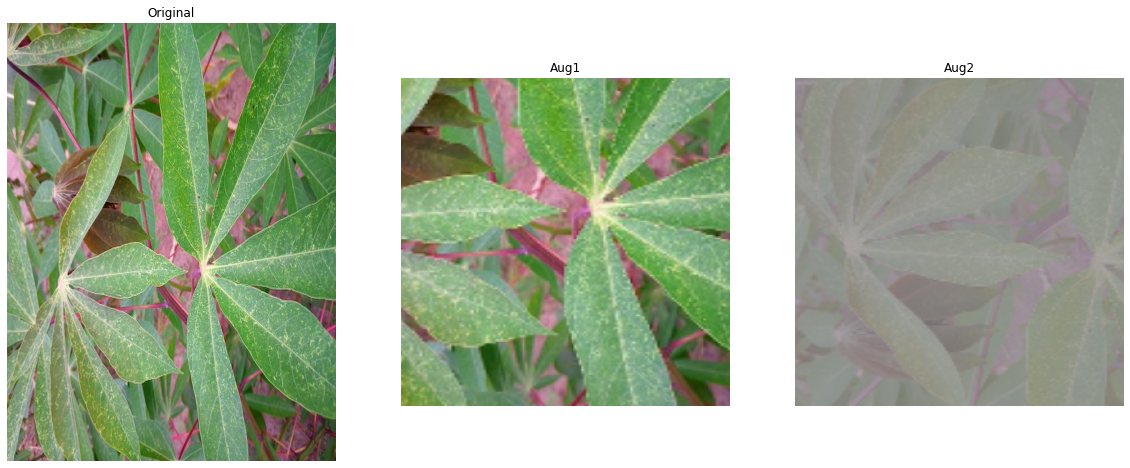

In [27]:
image1 = byol.augment(raw_image.unsqueeze(0)/255)[0]
image2 = byol.augment(raw_image.unsqueeze(0)/255)[0]

print(label)
plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plot_image(raw_image/255)
plt.title('Original')
plt.subplot(1, 3, 2)
plot_image(unnorm(image1))
plt.title('Aug1')
plt.subplot(1, 3, 3)
plot_image(unnorm(image2))
plt.title('Aug2')
plt.show()

# Train

In [28]:
trainer = Trainer.from_argparse_args(
    hparams_byol,
    reload_dataloaders_every_epoch = True,
#     gradient_clip_val = 0.5,
    terminate_on_nan = True,
)

GPU available: True, used: True


2020-12-13 14:53:03,303 - lightning - INFO - GPU available: True, used: True


TPU available: False, using: 0 TPU cores


2020-12-13 14:53:03,305 - lightning - INFO - TPU available: False, using: 0 TPU cores


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


2020-12-13 14:53:03,306 - lightning - INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [32]:
# lr_finder = trainer.tuner.lr_find(byol,
#                                   train_dataloader=train_data_loader,
#                                   val_dataloaders=[val_data_loader])
# plt.figure()
# plt.title('LR finder results')
# lr_finder.plot(suggest=True)
# plt.show()
# new_lr = lr_finder.suggestion()
# byol.hparams.lr = new_lr
# new_lr

In [33]:
trainer.fit(byol, train_data_loader, val_data_loader)


  | Name      | Type           | Params
---------------------------------------------
0 | augment   | Sequential     | 0     
1 | encoder   | EncoderWrapper | 10.3 M
2 | predictor | Linear         | 65.8 K
3 | _target   | EncoderWrapper | 10.3 M


2020-12-13 14:56:06,329 - lightning - INFO - 
  | Name      | Type           | Params
---------------------------------------------
0 | augment   | Sequential     | 0     
1 | encoder   | EncoderWrapper | 10.3 M
2 | predictor | Linear         | 65.8 K
3 | _target   | EncoderWrapper | 10.3 M


/home/boris/Documents/kaggle cassava/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


1

In [ ]:
byol = byol.eval()

In [ ]:
byol = byol.cuda()

In [ ]:
byol(raw_image.unsqueeze(0).to('cuda'))

In [ ]:
model = model.cuda()
model(raw_image.unsqueeze(0).to('cuda'))

# Supervised training and accuracy check

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
state_dict = byol.encoder.model.state_dict()
model = LeafDoctorModel(hparams)
model.trunk.load_state_dict(state_dict)

In [ ]:
early_stopping = EarlyStopping('val_acc',
                                   patience=parameters['early_stop_patience'],
                                   verbose=True,
                                   )

hparams = Namespace(**parameters)

trainer = Trainer.from_argparse_args(
    hparams,
    reload_dataloaders_every_epoch = True,
    callbacks=[early_stopping],
)

In [ ]:
trainer.fit(model, train_data_loader, val_data_loader)

In [ ]:
hparams

In [ ]:
parameters['classifier'] = parameters

In [ ]:
from cassava.pipelines.train_model.nodes import score_model

In [ ]:
model = model.cuda()

In [ ]:
scores, _ = score_model(model, train_images_torch, val_indices, parameters)

scores